In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import vsm
from pathlib import Path, PureWindowsPath
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 5)
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans les colonnes du dataframe

In [2]:
current_folder = PureWindowsPath(globals()['_dh'][0]).as_posix()
path_root = "/".join(current_folder.split("/")[:-1]) #remonter au dossier root du projet
os.chdir(path_root)
path = PureWindowsPath(os.getcwd() + "/data/input/data.parquet")
path = path.as_posix() #convertir en path linux (convertir les \\ en /)
corpus = pd.read_parquet(path) #engine="fastparquet"

zeros_subset = corpus.loc[corpus["category_bin"] == 0, :]
ones_subset = corpus.loc[corpus["category_bin"] == 1, :]
number_of_minority_class = len(zeros_subset)
sampled_ones = ones_subset.sample(number_of_minority_class, random_state=42)
print(sampled_ones.shape)
corpus = pd.concat([sampled_ones, zeros_subset], ignore_index=True)
corpus = corpus.sample(frac=1).reset_index(drop=True)
corpus.index = list(range(len(corpus)))
corpus["id"] = corpus.index	#creation de l'id seulement apres equilibrage des classes et melange aleatoire
print(corpus["category_bin"].value_counts())
print(corpus.id.duplicated().any())
print(corpus.index.duplicated().any())
corpus

(1825, 6)
1    1825
0    1825
Name: category_bin, dtype: int64
False
False


,id,message,message_preprocessed,category,length,category_bin
0,0,**Est ce que tous les noms de Dieu sont des métaphores?**,tous nom dieu métaphore,philosophy,57,1
1,1,"Rappelez vous que nous avons beaucoup insisté que nous ne verrons pas Dieu à travers des représentations, ni même ses attributs. Nous verrons tout Dieu directement, et tous ses attributs directement, sans représentations intermédiaires. Dès lors, puisque voir Dieu n’est pas voir une succession d’images de ce qu’il est, c’est que nous le voyons « tout à la fois ». En un seul coup.",rappelez beaucoup insisté verrons dieu travers représentation ni attribut verrons tout dieu directement tous attribut directement sans représentation intermédiaire dès lors puisque voir dieu voir succession image voyons « tout foi » seul coup,philosophy,387,1
...,...,...,...,...,...,...
3648,3648,"Plus nous avançons, et plus nous délaissons le consensus: les athées nous ont abandonnés à la question 2, et les panthéistes à la question 3 et on vient de perdre les déistes et les musulmans à la question 8. A la question 9, il n’est pas exclus que nous perdions aussi une fraction des évangéliques: En effet, deux forces intellectuelles semblent s’être liguées de façon surprenante pour redéfinir l’immutabilité de Dieu à l’intérieur de la communauté intellectuelle évangélique. D’un côté, les analytiques comme William Lane Craig et Alvin Platinga, de l’autre les réformés plus ou moins présuppositionnalistes comme John Frame, Scott Oliphint, J.I Packer, et autres. Ces deux écoles ont normalement peu de choses en commun, sinon un mépris marqué pour la théologie historique. Thomas d’Aquin est une figure de mépris commune entre William Lane Craig et John Frame, et la scholastique fait office de « suspect habituel ».",plus avançons plus délaissons consensus athée abandonné question panthéiste question vient perdre déiste musulman question a question exclu perdions aussi fraction évangélique effet deux force intellectuel semblent être liguées façon surprenante redéfinir immutabilité dieu intérieur communauté intellectuel évangélique côté analytique comme william lane craig alvin platinga autre réformé plus moins présuppositionnalistes comme john frame scott oliphint ji packer autres deux école normalement peu chose commun sinon mépris marqué théologie historique thomas aquin figure mépris commune entre william lane craig john frame scholastique fait office « suspect habituel »,philosophy,934,1
3649,3649,"° Actes 8:12-17 (première partie) Mais, quand ils eurent cru à Philippe, qui leur annonçait la bonne nouvelle de ce qui concerne le royaume de Dieu et le nom de Jésus-Christ, ils furent baptisés, tant les hommes que les femmes. °",degré acte - première partie quand cru philippe annonçait bonne nouvelle concerne royaume dieu nom jésus-christ baptisé tant homme femme degré,baptism,231,0


In [3]:
X = corpus["message_preprocessed"]
y = corpus["category"]
# y = corpus["category_bin"]
indices = corpus["id"]
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)

In [23]:
type(X_train_count)

scipy.sparse.csr.csr_matrix

In [4]:
count_vectorizer = CountVectorizer()
X_train_count = count_vectorizer.fit_transform(X_train)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

hashing_vectorizer = HashingVectorizer()
X_train_hashing = hashing_vectorizer.fit_transform(X_train)

X_train_observed_expected = vsm.observed_over_expected(X_train_count).round(2)
X_train_observed_expected = np.ravel(X_train_observed_expected)
X_train_observed_expected = np.delete(X_train_observed_expected, np.where(X_train_observed_expected == 0))


In [62]:
X_train_pmi[X_train_pmi != 0]

matrix([[5.15920653, 5.54219878, 8.25024898, ..., 1.49699532, 3.46275724,
         5.20322341]])

In [61]:
X_train_pmi = vsm.pmi(X_train_count)
# X_train_pmi_nnz = np.ravel(X_train_pmi_nnz)
print("X_train_count.shape =", X_train_count.shape)
# print("X_train_count.data.shape =", X_train_count.data.shape)
print("X_train_count.count_nonzero() =", X_train_count.count_nonzero())
print("X_train_tfidf.count_nonzero() =", X_train_count.count_nonzero())
print("X_train_pmi.shape =", X_train_pmi.shape)
# print("X_train_pmi_nnz.shape =", X_train_pmi[X_train_pmi != 0].shape)

X_train_count.shape = (2445, 9540)
X_train_count.count_nonzero() = 60254
X_train_tfidf.count_nonzero() = 60254
X_train_pmi.shape = (2445, 9540)
X_train_pmi_nnz.shape = (1, 60029)


In [6]:
np.set_printoptions(suppress=True)
# values, counts = np.unique(X_train_observed_expected, return_counts=True) #retourne des numpy.ndarray 
# np.asarray((values, counts)).T
X_train_observed_expected.shape

(2445, 9540)

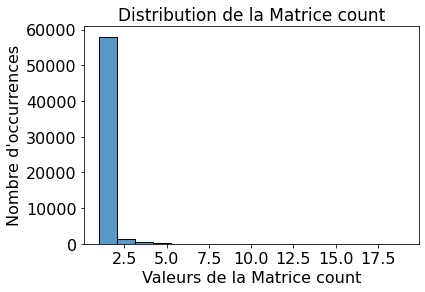

In [7]:
# Distribution des valeurs de la matrice count
path = PureWindowsPath(os.getcwd() + "\\data\\output\\count_matrix_distribution.png")
path = path.as_posix()

sb.histplot(X_train_count.data)
plt.xlabel("Valeurs de la Matrice count", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution de la Matrice count", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.savefig(path)
plt.show()


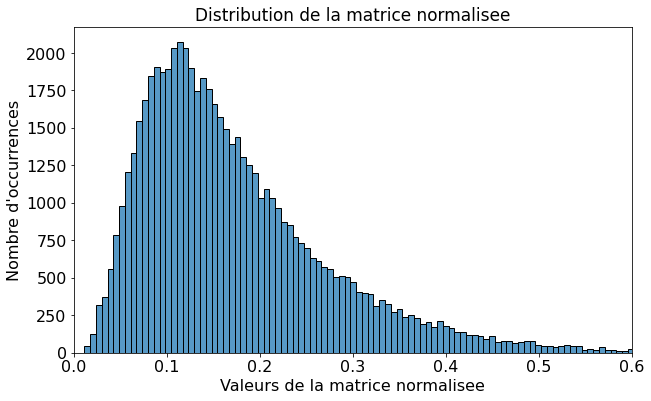

In [8]:
# Distribution des valeurs de la matrice normalization
from sklearn.preprocessing import normalize
X_train_normalized = normalize(X_train_count, norm='l2', axis=1) #normalisation par ligne

path = PureWindowsPath(os.getcwd() + "\\data\\output\\normalization_distribution.png")
path = path.as_posix()

sb.histplot(X_train_tfidf.data, edgecolor="black", linewidth=1)
plt.xlabel("Valeurs de la matrice normalisee", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution de la matrice normalisee", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

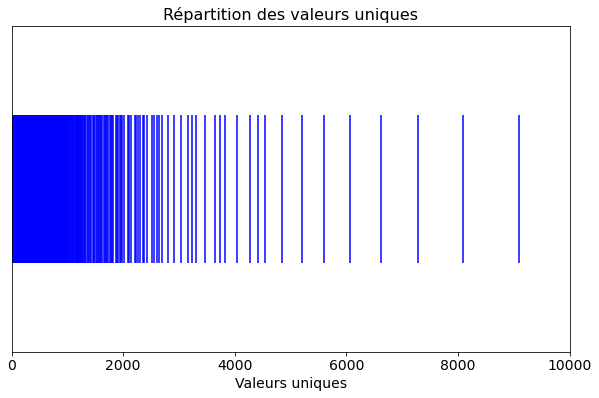

In [30]:
# Graphique avec barres en 1D des valeurs uniques (pour voir comment elles sont reparties, que a droite ?, que a gauche ?, etc.)
# sb.scatterplot(x=X_tfidf_unique, y=np.zeros_like(X_tfidf_unique), sizes=(10000,10000))
path = PureWindowsPath(os.getcwd() + "\\data\\output\\observed_expected_matrix_unique_distribution.png")
path = path.as_posix()

plt.figure()
plt.hlines(0,0,1)  # Draw a horizontal line
plt.eventplot(np.unique(X_train_observed_expected), orientation='horizontal', colors='b')
plt.xlabel("Valeurs uniques", size=14)
plt.title("Répartition des valeurs uniques", size=16)
plt.xticks(fontsize=14)
ax = plt.gca()
ax.get_yaxis().set_visible(False)
plt.rcParams["figure.figsize"] = (9, 4)
plt.xlim(0, 10000)
plt.savefig(path)
plt.show()

In [24]:
import plotly.express as px
fig = px.histogram(X_train_observed_expected)
fig.update_traces(marker_line_width=1, marker_line_color="white")
fig.show()

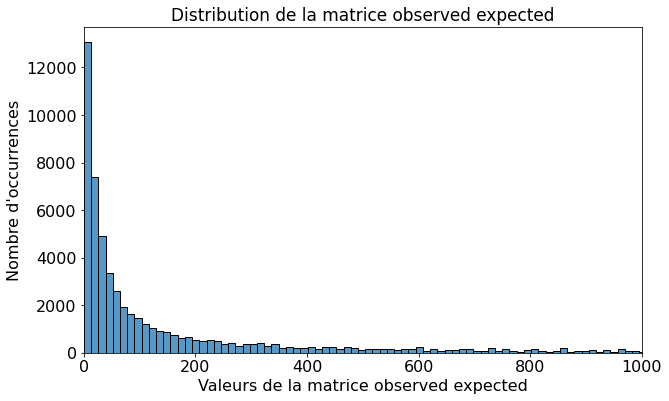

In [32]:
# Distribution des valeurs de la matrice observed expected
path = PureWindowsPath(os.getcwd() + "\\data\\output\\observed_expected_matrix_distribution.png")
path = path.as_posix()

sb.histplot(X_train_observed_expected, edgecolor="black", linewidth=1)
plt.xlabel("Valeurs de la matrice observed expected", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution de la matrice observed expected", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(0, 1000)
plt.savefig(path)
plt.show()

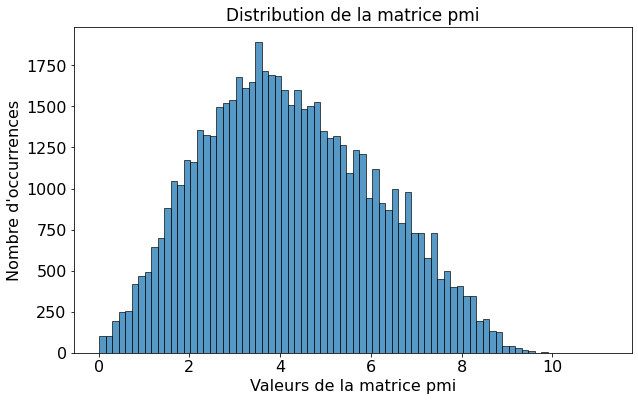

In [29]:
# Distribution des valeurs de la matrice X_train_pmi
path = PureWindowsPath(os.getcwd() + "\\data\\output\\pmi_matrix_distribution.png")
path = path.as_posix()

sb.histplot(X_train_pmi)
plt.xlabel("Valeurs de la matrice pmi", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution de la matrice pmi", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.savefig(path)
plt.show()

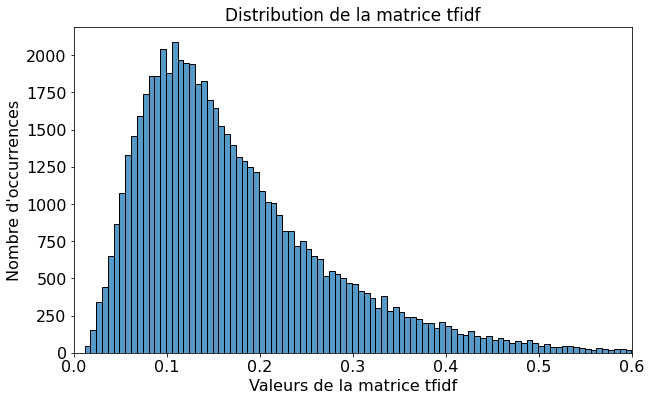

In [13]:
# Distribution des valeurs de la matrice tfidf
path = PureWindowsPath(os.getcwd() + "\\data\\output\\tfidf_distribution.png")
path = path.as_posix()

sb.histplot(X_train_tfidf.data, edgecolor="black", linewidth=1)
plt.xlabel("Valeurs de la matrice tfidf", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution de la matrice tfidf", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

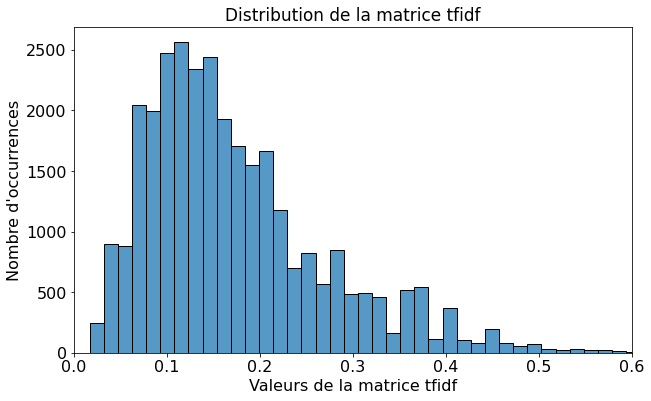

In [18]:
# Distribution des valeurs de la matrice hashing
path = PureWindowsPath(os.getcwd() + "\\data\\output\\tfidf_distribution.png")
path = path.as_posix()

sb.histplot(X_train_hashing.data, edgecolor="black", linewidth=1)
plt.xlabel("Valeurs de la matrice tfidf", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution de la matrice tfidf", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

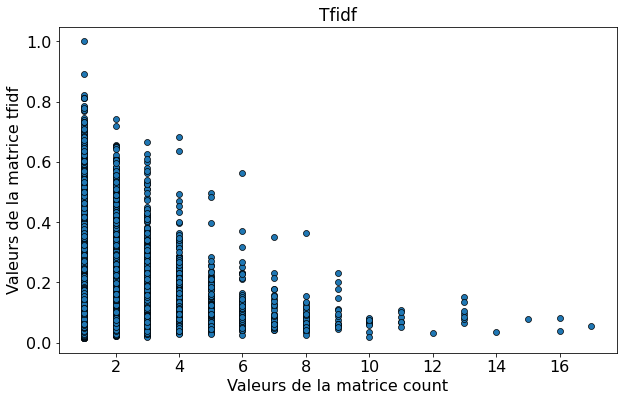

In [12]:
# Distribution matrice matrice
# Distribution des valeurs de la matrice tfidf
path = PureWindowsPath(os.getcwd() + "\\data\\output\\tfidf_vs_count_distribution.png")
path = path.as_posix()

sb.scatterplot(x=X_train_count.data, y=X_train_tfidf.data, edgecolor="black", linewidth=0.7)
plt.xlabel("Valeurs de la matrice count", size=16)
plt.ylabel("Valeurs de la matrice tfidf", size=16)
plt.title("Tfidf", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
# plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

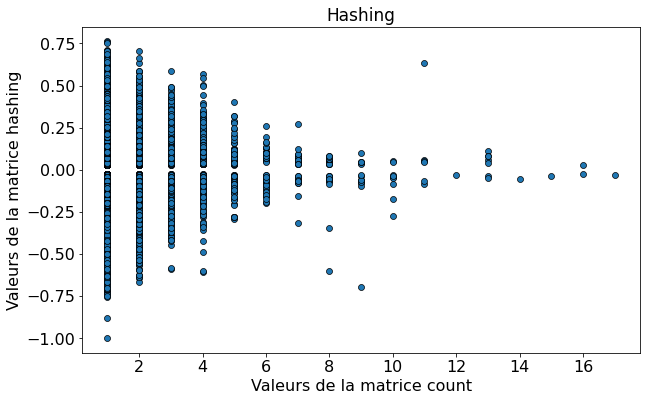

In [15]:
# Distribution matrice matrice
# Distribution des valeurs de la matrice hashing
path = PureWindowsPath(os.getcwd() + "\\data\\output\\hashing_vs_count_distribution.png")
path = path.as_posix()

sb.scatterplot(x=X_train_count.data, y=X_train_hashing.data, edgecolor="black", linewidth=0.7)
plt.xlabel("Valeurs de la matrice count", size=16)
plt.ylabel("Valeurs de la matrice hashing", size=16)
plt.title("Hashing", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
# plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

In [ ]:
# Distribution matrice matrice
# Distribution des valeurs de la matrice expected observed
path = PureWindowsPath(os.getcwd() + "\\data\\output\\hashing_vs_count_distribution.png")
path = path.as_posix()

sb.scatterplot(x=X_train_count.data, y=np.ravel(X_train_observed_expected[X_train_observed_expected != 0]), 
                edgecolor="black", linewidth=0.7)
plt.xlabel("Valeurs de la matrice count", size=16)
plt.ylabel("Valeurs de la matrice hashing", size=16)
plt.title("Hashing", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
# plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

In [77]:
print(2445 * 9540)
print(X_train_count.shape)
print(X_train_pmi.shape)

23325300
(2445, 9540)
(2445, 9540)


In [83]:
np.ravel(X_train_pmi)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

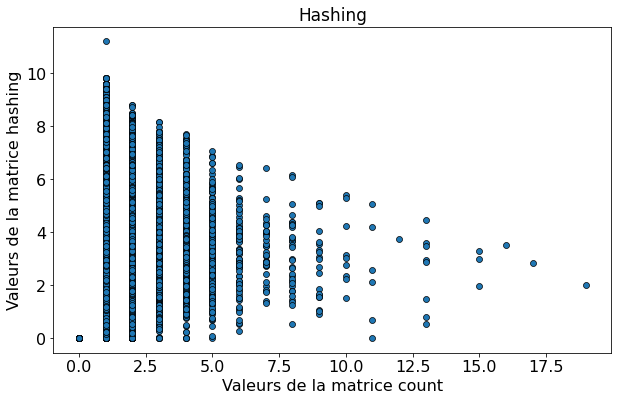

In [84]:
# Distribution matrice matrice
# Distribution des valeurs de la matrice pmi
path = PureWindowsPath(os.getcwd() + "\\data\\output\\hashing_vs_count_distribution.png")
path = path.as_posix()

sb.scatterplot(x=np.ravel(X_train_count.toarray()), y=np.ravel(X_train_pmi), edgecolor="black", linewidth=0.7)
plt.xlabel("Valeurs de la matrice count", size=16)
plt.ylabel("Valeurs de la matrice pmi", size=16)
plt.title("Hashing", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
# plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

,0,1,2
0,1.031250,0.750000,1.145833
1,0.750000,1.090909,1.000000
2,1.178571,1.071429,0.916667
